In [1]:
#### Imports para entrenamiento, predicción y evaluación del modelo ####
#### NO QUITAR ####
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
#### Código Agregado ####
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings(action="ignore")

In [7]:
### Loading Data
data = pd.read_csv('base_tarjeta_credito.csv')

In [15]:
data.head()

,Unnamed: 0,email,cliente,FechaSaldos,periodo_cli,periodo,cant_productos,cant_PF,cant_TC,cant_PP,...,cant_PP_ant_2,SaldoPromedioCAPesos_ant_2,SaldoPromedioCADolares_ant_2,SaldoPromedioCCAcreedor_ant_2,importe_consumos_ant_2,TotalConsumoTD_ant_2,cuotas_faltantes_2,score_deuda,target,target2
0,0,cliente@mail.com,0,2019-12-06 09:45:00,24240,24240,2,0,0,0,...,0,9440.56,0.00,0.0,0,4577.00,0,NaN,0.0,0.0
1,1,cliente@mail.com,1,2019-12-06 09:45:00,24240,24240,1,0,0,0,...,0,5029.59,0.00,0.0,0,8813.89,0,NaN,0.0,0.0
2,2,cliente@mail.com,2,2019-12-06 09:45:00,24240,24240,1,0,0,0,...,0,50156.32,0.00,0.0,0,10387.20,0,0.0,0.0,0.0
3,3,cliente@mail.com,3,2019-12-06 09:45:00,24240,24240,6,0,3,0,...,0,26082.85,0.00,0.0,0,600.00,0,1.0,0.0,0.0
4,4,cliente@mail.com,4,2019-12-06 09:45:00,24240,24240,6,1,2,0,...,0,103080.40,470.04,0.0,0,1618.19,0,0.0,0.0,1.0


In [10]:
data.shape

(494887, 44)

In [11]:
data.nunique()

Unnamed: 0                       247789
email                                 1
cliente                          247789
FechaSaldos                           3
periodo_cli                           3
periodo                               3
cant_productos                       58
cant_PF                              44
cant_TC                              25
cant_PP                               6
FechaUltMovCA                       971
cant_seguros                         18
importe_consumos                    317
Edad                                115
Sexo                                  3
SaldoPromedioCAPesos             411491
SaldoPromedioCADolares            63559
SaldoPromedioCCAcreedor           11063
TotalConsumoTD                   187122
TipoCuentaAcredHab                    1
CategoriaProducto                    28
FechaVinculacion                   5134
cuotas_faltantes_1                  271
cant_PF_ant_1                        43
cant_TC_ant_1                        25


In [53]:
#veremos aquellas columnas que tienen el mismo valor en todas las filas (un unico valor, por eso el 1)
#entonces sabremos que estas columnas no aportan nada
to_remove = [x for x in data.columns if data[x].nunique()==1]

In [54]:
#eliminamos las columnas que tienen el mismo valor para todos los registros 
data.drop(columns=to_remove,inplace=True)

In [16]:
data.duplicated().any() # no hay duplicados de registros 

False

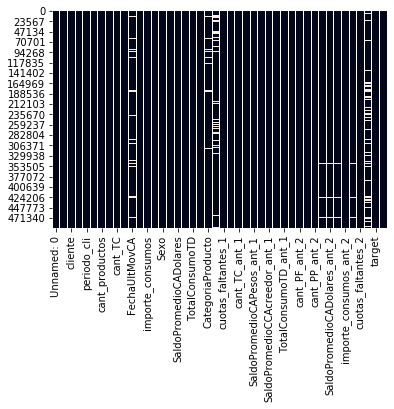

In [18]:
#CHEQUEAREMOS NULOS 

sns.heatmap(data[data.columns[0:45]].isnull(), cbar=False)
#no se visualiza bien asi que haremos heatmaps incluyendo menos columnas para analizar mejor 

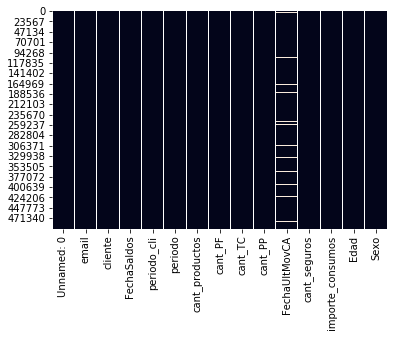

In [20]:
sns.heatmap(data[data.columns[0:15]].isnull(), cbar=False)
#Vemos muchos nulos en FechaUltMovCA

In [24]:
data['FechaUltMovCA']

0         2019-12-02 00:00:00
1         2019-12-04 00:00:00
2         2019-12-05 00:00:00
3         2019-12-05 00:00:00
4         2019-12-05 00:00:00
                 ...         
494882    2020-02-06 00:00:00
494883    2019-05-22 00:00:00
494884    2019-09-27 00:00:00
494885    2020-02-06 00:00:00
494886    2020-02-06 00:00:00
Name: FechaUltMovCA, Length: 494887, dtype: object

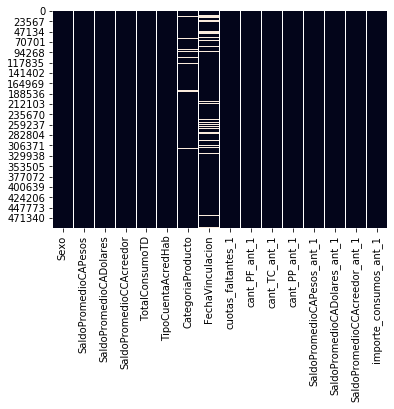

In [29]:
sns.heatmap(data[data.columns[14:30]].isnull(), cbar=False)
#fecha vinculacion tiene muchos nulos tambien, la trabajaremos para ver si hay periodos no consecutivos con altas 

In [27]:
data['CategoriaProducto']

0         JUB00021
1         JUB00021
2         JUB00021
3         JUB00021
4         K  00021
            ...   
494882    PRI00001
494883    PRI00001
494884    PRI00001
494885    PRI00001
494886    CON00001
Name: CategoriaProducto, Length: 494887, dtype: object

In [28]:
data['FechaVinculacion']

0         2017-07-26 00:00:00
1         2015-09-25 00:00:00
2                         NaN
3                         NaN
4                         NaN
                 ...         
494882    2014-06-06 00:00:00
494883    2016-01-15 00:00:00
494884    2018-04-19 00:00:00
494885    2018-04-11 00:00:00
494886    2019-11-26 00:00:00
Name: FechaVinculacion, Length: 494887, dtype: object

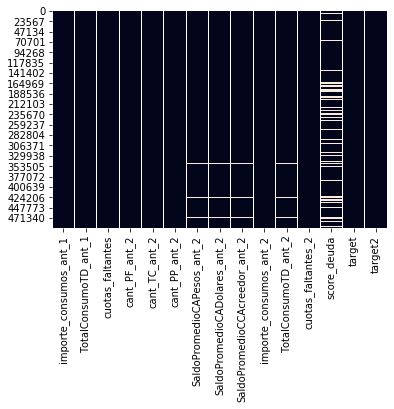

In [30]:
sns.heatmap(data[data.columns[29:46]].isnull(), cbar=False)
#score deuda tiene muchos nulos tambien pero sabemos que equivalen a no tener deuda
#vemos otros nulos en otras 4 columnas que son igual para todos los registros 

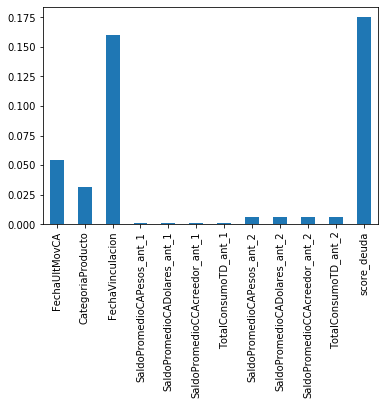

In [32]:
#contaremos la cantidad de nulos para cada columna 
nullcount = {col:data[col].isnull().sum() for col in data.columns}
#y haremos una serie con estos valores para graficarlo como grafico de barras
missing = pd.Series(nullcount)
#ahora graficamos valores relativos solamente de las variables que contienen nulos, por eso usamos div
missing[missing>0].div(data.shape[0]).plot.bar()

In [33]:
#ahora trabajaremos con la fecha de vinculacion
data['FechaVinculacion'].dtype

dtype('O')

In [39]:
data['Date'] = pd.to_datetime(data['FechaVinculacion'])

In [40]:
data['Month'] = data['Date'].dt.month # obtenemos el numero de mes
data['Year'] = data['Date'].dt.year # obtenemos el año
data['Period'] = data['Date'].dt.to_period('M') # obtenemos el periodo, en formato año/mes
data.sort_values('Date', inplace=True) # ordenamos por fecha de activacion a los datos

In [42]:
#Tambien podemos hacer una tabla pivot usando como indice el año y como columna los meses
pd.pivot_table(data=data, 
               index=['Year'],
               columns=['Month'],
               aggfunc=['size']
              )

size                                                           \
Month     1.0     2.0     3.0     4.0     5.0     6.0     7.0      8.0    
Year                                                                      
1990.0    26.0     NaN     NaN     NaN     NaN     NaN     NaN      NaN   
1995.0     2.0     2.0     2.0     NaN     NaN     NaN     NaN      NaN   
1996.0     NaN     NaN     3.0     NaN     NaN     NaN     NaN      NaN   
1997.0     NaN     NaN     2.0     NaN     NaN     NaN     NaN      NaN   
1998.0     NaN     NaN     NaN     2.0     NaN     NaN     NaN      NaN   
1999.0     NaN     NaN     2.0     NaN  1002.0  1966.0   943.0   1524.0   
2000.0   539.0   585.0   620.0   820.0   894.0   657.0   655.0    769.0   
2001.0   703.0   521.0   561.0   670.0   812.0   610.0   786.0    773.0   
2002.0   841.0   576.0   714.0   469.0   800.0  1023.0   710.0    661.0   
2003.0   559.0   511.0   627.0   819.0   787.0   899.0   812.0    738.0   
2004.0   647.0   711.0  1184.0  1004.0   982.0  1040.0  1104.0   1138.0   
2005.0   740.0   682.0   942.0  1523.0  1255.0  1294.0  1080.0   1143.0   
2006.0   959.0   758.0  1071.0  1261.0  1172.0  1122.0  1356.0   1150.0   
2007.0  1278.0  1001.0  1490.0  1299.0  1530.0  1627.0  1598.0   1422.0   
2008.0  1138.0   879.0   942.0  1288.0  1644.0  1270.0  1533.0   1497.0   
2009.0   676.0   696.0   883.0  1114.0  1513.0  1502.0  1372.0   1156.0   
2010.0  1092.0   882.0  8354.0  1073.0  1589.0  1872.0  1812.0   1792.0   
2011.0  1168.0  1239.0  1375.0  1595.0  2050.0  2047.0  2122.0   1884.0   
2012.0  1503.0  2305.0  2181.0  1726.0  2871.0  1885.0  1725.0   1821.0   
2013.0  1676.0  1482.0  1783.0  2020.0  2208.0  1880.0  2494.0   2352.0   
2014.0  1715.0  1635.0  1778.0  2416.0  2092.0  2105.0  2647.0   2271.0   
2015.0  1576.0  1484.0  1862.0  3031.0  2537.0  2813.0  2357.0   1813.0   
2016.0  1713.0  1799.0  2577.0  3580.0  4488.0  2933.0  3619.0   2942.0   
2017.0  3064.0  3583.0  4111.0  4525.0  4119.0  4685.0  5483.0  12074.0   
2018.0  2301.0  1875.0  2130.0  3267.0  2750.0  2598.0  2424.0   2325.0   
2019.0  2332.0  2745.0  3548.0  2589.0  1947.0  1716.0  1366.0   1053.0   
2020.0    59.0     9.0     NaN     NaN     NaN     NaN     NaN      NaN   

                                        
Month     9.0     10.0    11.0    12.0  
Year                                    
1990.0     NaN     NaN     NaN     NaN  
1995.0     5.0     NaN     NaN     NaN  
1996.0     1.0     NaN     NaN     NaN  
1997.0     NaN     NaN     NaN     NaN  
1998.0     NaN     NaN     NaN     NaN  
1999.0   999.0   759.0   602.0   541.0  
2000.0   559.0   902.0   632.0   640.0  
2001.0   856.0   757.0   715.0  1727.0  
2002.0   856.0   724.0   627.0   572.0  
2003.0  1055.0   747.0   685.0   680.0  
2004.0  1000.0   866.0  1001.0   941.0  
2005.0  1240.0  1194.0  1110.0   953.0  
2006.0  1356.0  1205.0  1234.0  1942.0  
2007.0  1232.0  1334.0  1411.0  1112.0  
2008.0  1468.0  1338.0  1055.0  1021.0  
2009.0  1517.0  1214.0  1462.0  1454.0  
2010.0  1490.0  1538.0  1526.0  1487.0  
2011.0  1870.0  1900.0  1479.0  1422.0  
2012.0  1412.0  2102.0  1971.0  1351.0  
2013.0  2406.0  2506.0  2471.0  1790.0  
2014.0  2069.0  2315.0  1738.0  1640.0  
2015.0  2156.0  2306.0  1873.0  1716.0  
2016.0  3431.0  3634.0  3571.0  2549.0  
2017.0  4046.0  3017.0  2679.0  2331.0  
2018.0  2182.0  2695.0  3751.0  2019.0  
2019.0  1240.0  1845.0  1975.0   841.0  
2020.0     NaN     NaN     NaN     NaN

In [43]:
#vemos que hay muchos periodos con valores nulos, asi que nos quedamos con los datos desde mayo del 99 en adelante
period = pd.to_datetime('1999-05').to_period('M') 

In [44]:
data = data[data['Period']>=period]

In [46]:
#veremos como quedo ahora la tabla sin los valores que eliminamos
pd.pivot_table(data,
               index=['Year'],
               columns=['Month'],
               aggfunc=['size']
              )

size                                                           \
Month     1.0     2.0     3.0     4.0     5.0     6.0     7.0      8.0    
Year                                                                      
1999.0     NaN     NaN     NaN     NaN  1002.0  1966.0   943.0   1524.0   
2000.0   539.0   585.0   620.0   820.0   894.0   657.0   655.0    769.0   
2001.0   703.0   521.0   561.0   670.0   812.0   610.0   786.0    773.0   
2002.0   841.0   576.0   714.0   469.0   800.0  1023.0   710.0    661.0   
2003.0   559.0   511.0   627.0   819.0   787.0   899.0   812.0    738.0   
2004.0   647.0   711.0  1184.0  1004.0   982.0  1040.0  1104.0   1138.0   
2005.0   740.0   682.0   942.0  1523.0  1255.0  1294.0  1080.0   1143.0   
2006.0   959.0   758.0  1071.0  1261.0  1172.0  1122.0  1356.0   1150.0   
2007.0  1278.0  1001.0  1490.0  1299.0  1530.0  1627.0  1598.0   1422.0   
2008.0  1138.0   879.0   942.0  1288.0  1644.0  1270.0  1533.0   1497.0   
2009.0   676.0   696.0   883.0  1114.0  1513.0  1502.0  1372.0   1156.0   
2010.0  1092.0   882.0  8354.0  1073.0  1589.0  1872.0  1812.0   1792.0   
2011.0  1168.0  1239.0  1375.0  1595.0  2050.0  2047.0  2122.0   1884.0   
2012.0  1503.0  2305.0  2181.0  1726.0  2871.0  1885.0  1725.0   1821.0   
2013.0  1676.0  1482.0  1783.0  2020.0  2208.0  1880.0  2494.0   2352.0   
2014.0  1715.0  1635.0  1778.0  2416.0  2092.0  2105.0  2647.0   2271.0   
2015.0  1576.0  1484.0  1862.0  3031.0  2537.0  2813.0  2357.0   1813.0   
2016.0  1713.0  1799.0  2577.0  3580.0  4488.0  2933.0  3619.0   2942.0   
2017.0  3064.0  3583.0  4111.0  4525.0  4119.0  4685.0  5483.0  12074.0   
2018.0  2301.0  1875.0  2130.0  3267.0  2750.0  2598.0  2424.0   2325.0   
2019.0  2332.0  2745.0  3548.0  2589.0  1947.0  1716.0  1366.0   1053.0   
2020.0    59.0     9.0     NaN     NaN     NaN     NaN     NaN      NaN   

                                        
Month     9.0     10.0    11.0    12.0  
Year                                    
1999.0   999.0   759.0   602.0   541.0  
2000.0   559.0   902.0   632.0   640.0  
2001.0   856.0   757.0   715.0  1727.0  
2002.0   856.0   724.0   627.0   572.0  
2003.0  1055.0   747.0   685.0   680.0  
2004.0  1000.0   866.0  1001.0   941.0  
2005.0  1240.0  1194.0  1110.0   953.0  
2006.0  1356.0  1205.0  1234.0  1942.0  
2007.0  1232.0  1334.0  1411.0  1112.0  
2008.0  1468.0  1338.0  1055.0  1021.0  
2009.0  1517.0  1214.0  1462.0  1454.0  
2010.0  1490.0  1538.0  1526.0  1487.0  
2011.0  1870.0  1900.0  1479.0  1422.0  
2012.0  1412.0  2102.0  1971.0  1351.0  
2013.0  2406.0  2506.0  2471.0  1790.0  
2014.0  2069.0  2315.0  1738.0  1640.0  
2015.0  2156.0  2306.0  1873.0  1716.0  
2016.0  3431.0  3634.0  3571.0  2549.0  
2017.0  4046.0  3017.0  2679.0  2331.0  
2018.0  2182.0  2695.0  3751.0  2019.0  
2019.0  1240.0  1845.0  1975.0   841.0  
2020.0     NaN     NaN     NaN     NaN

In [47]:
#ahora vemos que en la tabla quedaron muchos valores nulos (los Nan) a estos los reemplazaremos por 0
#con el argumento fill_value
pivot_table = pd.pivot_table(data,
                               index=['Year'],
                               columns=['Month'],
                               aggfunc=['size'],
                               fill_value=0 # le asignamos un valor a los nan
                              )
pivot_table

size                                                               \
Month   1.0   2.0   3.0   4.0   5.0   6.0   7.0    8.0   9.0   10.0  11.0   
Year                                                                        
1999.0     0     0     0     0  1002  1966   943   1524   999   759   602   
2000.0   539   585   620   820   894   657   655    769   559   902   632   
2001.0   703   521   561   670   812   610   786    773   856   757   715   
2002.0   841   576   714   469   800  1023   710    661   856   724   627   
2003.0   559   511   627   819   787   899   812    738  1055   747   685   
2004.0   647   711  1184  1004   982  1040  1104   1138  1000   866  1001   
2005.0   740   682   942  1523  1255  1294  1080   1143  1240  1194  1110   
2006.0   959   758  1071  1261  1172  1122  1356   1150  1356  1205  1234   
2007.0  1278  1001  1490  1299  1530  1627  1598   1422  1232  1334  1411   
2008.0  1138   879   942  1288  1644  1270  1533   1497  1468  1338  1055   
2009.0   676   696   883  1114  1513  1502  1372   1156  1517  1214  1462   
2010.0  1092   882  8354  1073  1589  1872  1812   1792  1490  1538  1526   
2011.0  1168  1239  1375  1595  2050  2047  2122   1884  1870  1900  1479   
2012.0  1503  2305  2181  1726  2871  1885  1725   1821  1412  2102  1971   
2013.0  1676  1482  1783  2020  2208  1880  2494   2352  2406  2506  2471   
2014.0  1715  1635  1778  2416  2092  2105  2647   2271  2069  2315  1738   
2015.0  1576  1484  1862  3031  2537  2813  2357   1813  2156  2306  1873   
2016.0  1713  1799  2577  3580  4488  2933  3619   2942  3431  3634  3571   
2017.0  3064  3583  4111  4525  4119  4685  5483  12074  4046  3017  2679   
2018.0  2301  1875  2130  3267  2750  2598  2424   2325  2182  2695  3751   
2019.0  2332  2745  3548  2589  1947  1716  1366   1053  1240  1845  1975   
2020.0    59     9     0     0     0     0     0      0     0     0     0   

              
Month   12.0  
Year          
1999.0   541  
2000.0   640  
2001.0  1727  
2002.0   572  
2003.0   680  
2004.0   941  
2005.0   953  
2006.0  1942  
2007.0  1112  
2008.0  1021  
2009.0  1454  
2010.0  1487  
2011.0  1422  
2012.0  1351  
2013.0  1790  
2014.0  1640  
2015.0  1716  
2016.0  2549  
2017.0  2331  
2018.0  2019  
2019.0   841  
2020.0     0

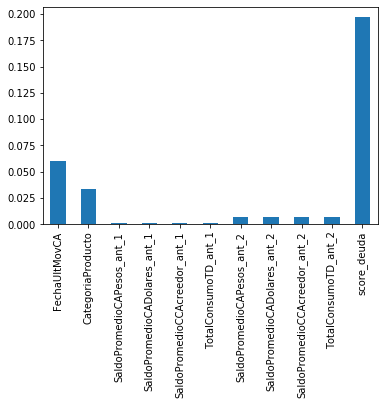

In [48]:
#vamos a volver a ver los valores nulos como quedaron luego de eliminar estos registros  
nullcount = {col:data[col].isnull().sum() for col in data.columns}
missing = pd.Series(nullcount)
missing[missing>0].div(data.shape[0]).plot.bar()

In [49]:
#los valores nulos que vemos en score_deuda es lo mismo que decir que el cliente no posea deudas
#asi que a los nulos los pasaremos a 1 , y a los valores que sean 0 tambien los pasaremos a 1 
data.loc[data['score_deuda'].isnull(),'score_deuda']=1

In [ ]:
#falta reemplazar los que son 0s por 1s

In [57]:
#eliminaremos los nulos de la columna SaldoPromedioCAPesos_ant_2 y veremos si asi eliminamos los nulos de las otras 3 columnas
#relacionadas a ant_2 tmb 
data.drop(data[data['SaldoPromedioCAPesos_ant_2'].isnull()].index, inplace = True)

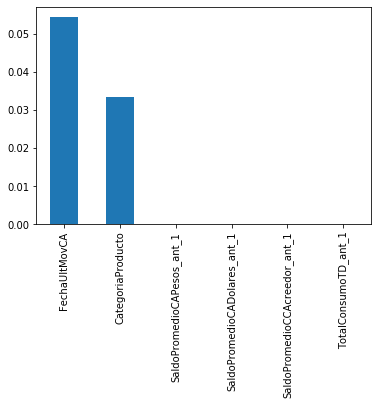

In [58]:
nullcount = {col:data[col].isnull().sum() for col in data.columns}
missing = pd.Series(nullcount)
missing[missing>0].div(data.shape[0]).plot.bar()

In [59]:
#efectivamente eliminamos esos nulos y ahora haremos lo mismo con las columnas relacionadas ant1 
data.drop(data[data['SaldoPromedioCAPesos_ant_1'].isnull()].index, inplace = True)

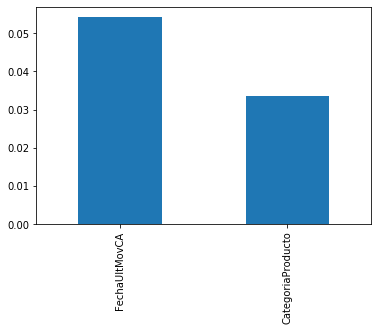

In [60]:
nullcount = {col:data[col].isnull().sum() for col in data.columns}
missing = pd.Series(nullcount)
missing[missing>0].div(data.shape[0]).plot.bar()